In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as mtri

# Physical constants
L, W = 1.0, 0.5    # domain size (cm)
lambda_, mu = 5e9, 5e9  # elastic constants (Pa)
h = 1.0            # thickness (cm)
sf = 1e9           # stress scaling

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # now outputs: u_x, u_y, E_xx, E_yy, E_xy
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 6)
        )

    def forward(self, x, y):
        # normalize into [-1,1]
        xi  = 2.0 * x / L
        eta = 2.0 * y / W

        raw = self.net(torch.cat([xi, eta], dim=1))
        # enforce zero displacement at x=-L/2 (Dirichlet on u_x,u_y)
        enforced = torch.zeros_like(raw)
        enforced[:,0] = (x.flatten() + L/2) * raw[:,0]  # u_x
        enforced[:,1] = (x.flatten() + L/2) * raw[:,1]  # u_y
        # strain outputs pass through directly
        enforced[:,2:] = raw[:,2:]
        return enforced

# compute true displacement gradients and small‐strain tensor via autograd
def strain_tensor(u_net, v_net, x, y):
    # ∂u/∂x, ∂u/∂y
    u_x_true = torch.autograd.grad(u_net, x,
                    grad_outputs=torch.ones_like(u_net),
                    retain_graph=True, create_graph=True)[0]
    u_y_true = torch.autograd.grad(u_net, y,
                    grad_outputs=torch.ones_like(u_net),
                    retain_graph=True, create_graph=True)[0]
    # ∂v/∂x, ∂v/∂y
    v_x_true = torch.autograd.grad(v_net, x,
                    grad_outputs=torch.ones_like(v_net),
                    retain_graph=True, create_graph=True)[0]
    v_y_true = torch.autograd.grad(v_net, y,
                    grad_outputs=torch.ones_like(v_net),
                    retain_graph=True, create_graph=True)[0]

    # small‐strain components
    E_xx = u_x_true
    E_yy = v_y_true
    E_xy = 0.5 * (u_y_true + v_x_true)

    return u_x_true, u_y_true, v_x_true, v_y_true, E_xx, E_yy, E_xy


# stress from strain (unchanged)
def stress_tensor(E_xx, E_yy, E_xy):
    tr = E_xx + E_yy
    s_xx = h * ((lambda_/sf) * tr + 2 * (mu/sf) * E_xx)
    s_yy = h * ((lambda_/sf) * tr + 2 * (mu/sf) * E_yy)
    s_xy = h * (2 * (mu/sf) * E_xy)
    return s_xx, s_yy, s_xy


# FO‐PINN physics loss with six‐output network: [u, v, u_x, u_y, v_x, v_y]
def physics_loss(model, x, y):
    x.requires_grad_(True)
    y.requires_grad_(True)

    out = model(x, y)
    # unpack network outputs
    u_net, v_net, u_x_net, u_y_net, v_x_net, v_y_net = (
        out[:,  i:i+1] for i in range(6)
    )

    # 1) true gradients & strains via autograd
    u_x_true, u_y_true, v_x_true, v_y_true, \
      E_xx_true, E_yy_true, E_xy_true = strain_tensor(u_net, v_net, x, y)

    # 2) compatibility loss
    w_comp = 4.0
    lc = (
        torch.mean((u_x_net - u_x_true)**2)
      + torch.mean((u_y_net - u_y_true)**2)
      + torch.mean((v_x_net - v_x_true)**2)
      + torch.mean((v_y_net - v_y_true)**2)
    ) * w_comp

    # 3) assemble network strains & compute stress
    E_xx_net, E_yy_net = u_x_net, v_y_net
    E_xy_net = 0.5 * (u_y_net + v_x_net)
    s_xx, s_yy, s_xy = stress_tensor(E_xx_net, E_yy_net, E_xy_net)

    # 4) first‐order PDE residuals
    s_xx_x = torch.autograd.grad(s_xx, x,
                 grad_outputs=torch.ones_like(s_xx),
                 retain_graph=True, create_graph=True)[0]
    s_xy_y = torch.autograd.grad(s_xy, y,
                 grad_outputs=torch.ones_like(s_xy),
                 retain_graph=True, create_graph=True)[0]
    s_yy_y = torch.autograd.grad(s_yy, y,
                 grad_outputs=torch.ones_like(s_yy),
                 retain_graph=True, create_graph=True)[0]
    s_xy_x = torch.autograd.grad(s_xy, x,
                 grad_outputs=torch.ones_like(s_xy),
                 retain_graph=True, create_graph=True)[0]

    rx = s_xx_x + s_xy_y
    ry = s_yy_y + s_xy_x
    lpde = torch.mean(rx**2 + ry**2)

    return lpde + lc


# BC loss
def boundary_condition_loss(model, L, W):
    w_A, w_D, w_C, w_B = 1.0, 1.0, 1.0, 1.0
    # A: x = -L/2, u=v=0
    y_A = torch.linspace(-W/2, W/2, 100).reshape(-1,1)
    x_A = -L/2 * torch.ones_like(y_A)
    out_A = model(x_A, y_A)
    u_A, v_A = out_A[:,0:1], out_A[:,1:2]
    loss_A = torch.mean(u_A**2 + v_A**2)
    # D: x = +L/2, u_x = 0.025L, u_y = 0
    x_D = L/2 * torch.ones_like(y_A)
    out_D = model(x_D, y_A)
    u_x_D, u_y_D = out_D[:,2:3], out_D[:,3:4]
    loss_D = torch.mean((u_x_D - 0.025*L)**2 + u_y_D**2)
    # C: y = 0 symmetry -> v=0 & sigma_xy=0
    x_C = torch.linspace(-L/2, L/2, 200).reshape(-1,1)
    y_C = torch.zeros_like(x_C)
    out_C = model(x_C, y_C)
    v_C = out_C[:,1:2]
    u_y_C, v_x_C = out_C[:,3:4], out_C[:,4:5]
    E_xy_C = 0.5*(u_y_C + v_x_C)
    _, _, s_xy_C = stress_tensor(out_C[:,2:3], out_C[:,5:6], E_xy_C)
    loss_C = torch.mean(v_C**2) + torch.mean(s_xy_C**2)
    # B: y = +W/2 traction-free -> sigma_yy=0, sigma_xy=0
    y_B = W/2 * torch.ones_like(x_C)
    out_B = model(x_C, y_B)
    E_xx_B, E_yy_B = out_B[:,2:3], out_B[:,5:6]
    E_xy_B = 0.5*(out_B[:,3:4] + out_B[:,4:5])
    _, s_yy_B, s_xy_B = stress_tensor(E_xx_B, E_yy_B, E_xy_B)
    loss_B = torch.mean(s_yy_B**2 + s_xy_B**2)
    return w_A*loss_A + w_D*loss_D + w_C*loss_C + w_B*loss_B


# train 
def train_pinn(model, optimizer, n_epochs, n_points, L, W):
    history = []
    w_pde, w_bc = 1.0, 50.0

    for ep in range(n_epochs):
        x = torch.rand(n_points,1)*L - L/2
        y = torch.rand(n_points,1)*W - W/2

        lp = physics_loss(model, x, y)           
        lb = boundary_condition_loss(model, L, W)  
        loss = w_pde*lp + w_bc*lb

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history.append(loss.item())
        if ep % 500 == 0:
            print(f"Epoch {ep:5d} │ Total: {loss.item():.3e} │ PDE+comp: {lp.item():.3e} │ BC: {lb.item():.3e}")
    return history

# initialize and run
model     = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10000
n_points = 1000
loss_history = train_pinn(model, optimizer, n_epochs, n_points, L, W)


Epoch     0 │ Total: 1.829e+02 │ PDE+comp: 8.486e-01 │ BC: 3.641e+00
Epoch   500 │ Total: 4.271e-03 │ PDE+comp: 3.348e-03 │ BC: 1.845e-05
Epoch  1000 │ Total: 9.838e-04 │ PDE+comp: 8.152e-04 │ BC: 3.372e-06
Epoch  1500 │ Total: 3.822e-04 │ PDE+comp: 3.199e-04 │ BC: 1.247e-06
Epoch  2000 │ Total: 2.037e-04 │ PDE+comp: 1.678e-04 │ BC: 7.177e-07
Epoch  2500 │ Total: 3.293e-04 │ PDE+comp: 1.242e-04 │ BC: 4.101e-06
Epoch  3000 │ Total: 1.514e-04 │ PDE+comp: 9.986e-05 │ BC: 1.031e-06
Epoch  3500 │ Total: 9.705e-05 │ PDE+comp: 8.279e-05 │ BC: 2.851e-07
Epoch  4000 │ Total: 9.167e-05 │ PDE+comp: 7.951e-05 │ BC: 2.431e-07
Epoch  4500 │ Total: 7.427e-05 │ PDE+comp: 6.650e-05 │ BC: 1.553e-07
Epoch  5000 │ Total: 6.035e-05 │ PDE+comp: 5.461e-05 │ BC: 1.148e-07
Epoch  5500 │ Total: 4.481e-02 │ PDE+comp: 1.297e-04 │ BC: 8.937e-04
Epoch  6000 │ Total: 4.642e-05 │ PDE+comp: 4.295e-05 │ BC: 6.922e-08
Epoch  6500 │ Total: 5.084e-05 │ PDE+comp: 3.523e-05 │ BC: 3.122e-07
Epoch  7000 │ Total: 5.182e-05 │ P

         X     Y    u_x_actual    u_y_actual  u_x_pred  u_y_pred  \
0    -0.50 -0.25  1.483633e-19  1.263433e-19  0.000000  0.000000   
1    -0.48 -0.25  9.101041e-04  9.363998e-04  0.000469  0.000291   
2    -0.50 -0.23 -1.530000e-20 -4.190000e-20  0.000000  0.000000   
3    -0.48 -0.23  5.332043e-04  6.506182e-04  0.000467  0.000266   
4    -0.50 -0.21  2.321675e-21 -6.630000e-21  0.000000  0.000000   
...    ...   ...           ...           ...       ...       ...   
1321  0.48  0.23  2.446680e-02 -6.510000e-04  0.024132 -0.002285   
1322  0.50  0.21  2.500000e-02  3.680167e-18  0.024603 -0.002112   
1323  0.48  0.25  2.408990e-02 -9.360000e-04  0.024144 -0.002459   
1324  0.50  0.23  2.500000e-02  1.768693e-18  0.024611 -0.002287   
1325  0.50  0.25  2.500000e-02  2.080774e-17  0.024625 -0.002461   

         error_u_x     error_u_y  percent_error_u_x  percent_error_u_y  
0     1.483633e-19  1.263433e-19           0.000000           0.000000  
1     4.415184e-04  6.456088e-04     

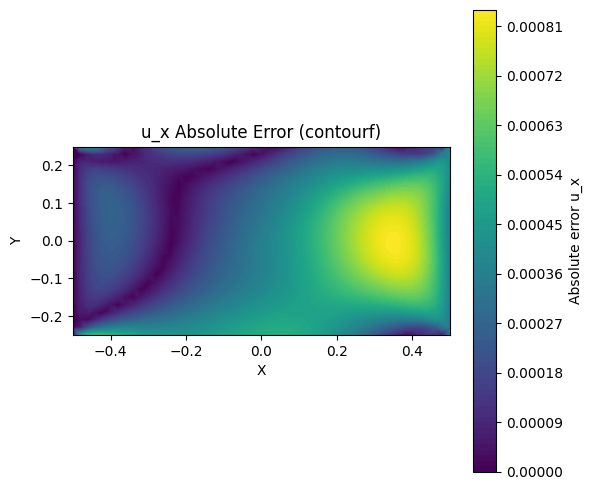

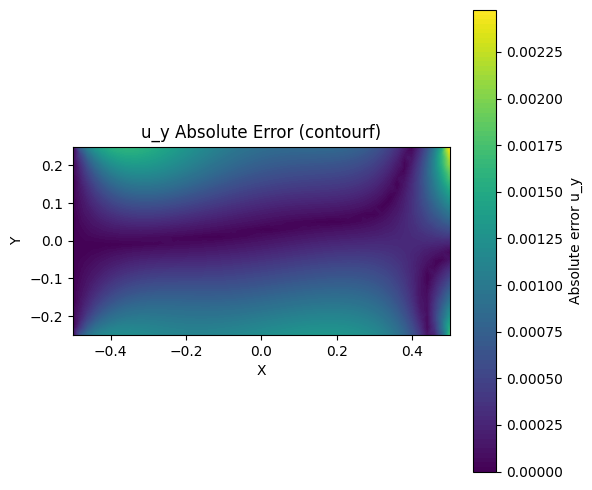

In [15]:
# read actual data
file_path       = '/Users/murat/Downloads/data.csv'
comparison_data = pd.read_csv(file_path)

x_values      = torch.tensor(comparison_data['X'].values, dtype=torch.float32).reshape(-1,1)
y_values      = torch.tensor(comparison_data['Y'].values, dtype=torch.float32).reshape(-1,1)
u_x_actual    = comparison_data['u_x_actual'].values
u_y_actual    = comparison_data['u_y_actual'].values

# predictions
model.eval()
with torch.no_grad():
    u_pred = model(x_values, y_values)
u_x_pred = u_pred[:,0].numpy()
u_y_pred = u_pred[:,1].numpy()

comparison_data['u_x_pred']        = u_x_pred
comparison_data['u_y_pred']        = u_y_pred
comparison_data['error_u_x']       = np.abs(u_x_actual - u_x_pred)
comparison_data['error_u_y']       = np.abs(u_y_actual - u_y_pred)

# percent error (safe)
comparison_data['percent_error_u_x'] = comparison_data.apply(
    lambda r: 0 if np.isclose(r.u_x_actual,0) else abs(r.u_x_actual - r.u_x_pred)/abs(r.u_x_actual)*100,
    axis=1
)
comparison_data['percent_error_u_y'] = comparison_data.apply(
    lambda r: 0 if np.isclose(r.u_y_actual,0) else abs(r.u_y_actual - r.u_y_pred)/abs(r.u_y_actual)*100,
    axis=1
)

print(comparison_data)

avg_px = comparison_data['percent_error_u_x'].mean()
avg_py = comparison_data['percent_error_u_y'].mean()
print(f"Average Percent Error for u_x: {avg_px:.2f}%")
print(f"Average Percent Error for u_y: {avg_py:.2f}%")

X = comparison_data['X'].values
Y = comparison_data['Y'].values
Ex = comparison_data['error_u_x'].values
Ey = comparison_data['error_u_y'].values

# build a Delaunay triangulation:
triang = mtri.Triangulation(X, Y)

# u_x absolute error
fig, ax = plt.subplots(figsize=(6,5))
tcf = ax.tricontourf(triang, Ex, levels=100, cmap='viridis')
fig.colorbar(tcf, ax=ax, label='Absolute error u_x')
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('u_x Absolute Error (contourf)')
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

# u_y absolute error
fig, ax = plt.subplots(figsize=(6,5))
tcf = ax.tricontourf(triang, Ey, levels=100, cmap='viridis')
fig.colorbar(tcf, ax=ax, label='Absolute error u_y')
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('u_y Absolute Error (contourf)')
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

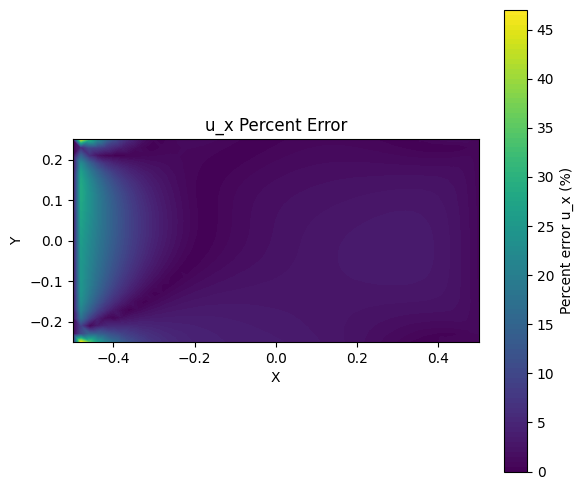

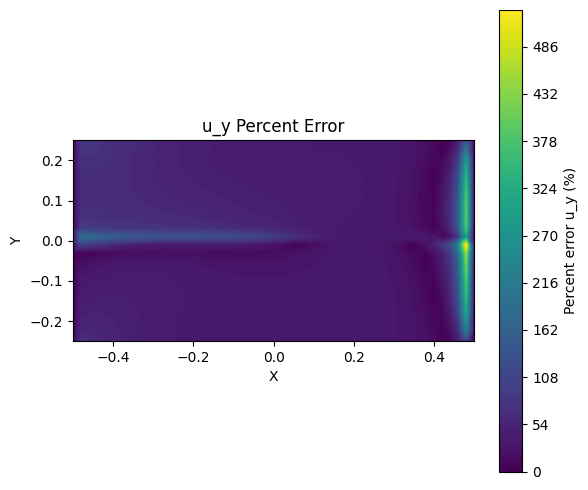

In [16]:
# u_x percent-error heatmap
fig, ax = plt.subplots(figsize=(6,5))
tcf = ax.tricontourf(triang, PEx, levels=100, cmap='viridis')
cbar = fig.colorbar(tcf, ax=ax, label='Percent error u_x (%)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('u_x Percent Error')
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

# u_y percent-error heatmap
fig, ax = plt.subplots(figsize=(6,5))
tcf = ax.tricontourf(triang, PEy, levels=100, cmap='viridis')
cbar = fig.colorbar(tcf, ax=ax, label='Percent error u_y (%)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('u_y Percent Error')
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()